Tensor Field Networks

Implementation of Newtonian gravity demonstration

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import random
from math import sqrt
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tensorfieldnetworks import utils 
from tensorfieldnetworks import layers
from tensorfieldnetworks.utils import EPSILON, FLOAT_TYPE

In [3]:
def R(inputs, nonlin=tf.nn.relu, hidden_dim=None, output_dim=1, weights_initializer=None, biases_initializer=None):
    with tf.variable_scope(None, "radial_function", values=[inputs]):
        if weights_initializer is None:
            weights_initializer = tf.contrib.layers.xavier_initializer()
        if biases_initializer is None:
            biases_initializer = tf.constant_initializer(0.)
        input_dim = inputs.get_shape()[-1]
        if hidden_dim is None:
            hidden_dim = input_dim

        w1 = tf.get_variable('weights1', [hidden_dim, input_dim], dtype=FLOAT_TYPE,
                             initializer=weights_initializer)
        b1 = tf.get_variable('biases1', [hidden_dim], dtype=FLOAT_TYPE, initializer=biases_initializer)

        w2 = tf.get_variable('weights2', [output_dim, hidden_dim], dtype=FLOAT_TYPE,
                             initializer=weights_initializer)
        b2 = tf.get_variable('biases2', [output_dim], dtype=FLOAT_TYPE, initializer=biases_initializer)

        hidden_layer = nonlin(b1 + tf.tensordot(inputs, w1, [[2], [1]]))
        radial = b2 + tf.tensordot(hidden_layer, w2, [[2], [1]])

        # [N, N, output_dim]
        return radial


def unit_vectors(v, axis=-1):
    return v / utils.norm_with_epsilon(v, axis=axis, keep_dims=True)


def Y_2(rij):
    # rij : [N, N, 3]
    # x, y, z : [N, N]
    x = rij[:, :, 0]
    y = rij[:, :, 1]
    z = rij[:, :, 2]
    r2 = tf.maximum(tf.reduce_sum(tf.square(rij), axis=-1), EPSILON)
    # return : [N, N, 5]
    output = tf.stack([x * y / r2,
                       y * z / r2,
                       (-tf.square(x) - tf.square(y) + 2. * tf.square(z)) / (2 * sqrt(3) * r2),
                       z * x / r2,
                       (tf.square(x) - tf.square(y)) / (2. * r2)],
                      axis=-1)
    return output


def F_0(inputs, nonlin=tf.nn.relu, hidden_dim=None, output_dim=1,
        weights_initializer=None, biases_initializer=None):
    # [N, N, output_dim, 1]
    with tf.variable_scope(None, "F_0", values=[inputs]):
        return tf.expand_dims(
            R(inputs, nonlin=nonlin, hidden_dim=hidden_dim, output_dim=output_dim,
              weights_initializer=weights_initializer, biases_initializer=biases_initializer),
            axis=-1)


def F_1(inputs, rij, nonlin=tf.nn.relu, hidden_dim=None, output_dim=1,
        weights_initializer=None, biases_initializer=None):
    with tf.variable_scope(None, "F_1", values=[inputs]):
        # [N, N, output_dim]
        radial = R(inputs, nonlin=nonlin, hidden_dim=hidden_dim, output_dim=output_dim,
                   weights_initializer=weights_initializer, biases_initializer=biases_initializer)
        # Mask out for dij = 0
        dij = tf.norm(rij, axis=-1)
        condition = tf.tile(tf.expand_dims(dij < EPSILON, axis=-1), [1, 1, output_dim])
        masked_radial = tf.where(condition, tf.zeros_like(radial), radial)
        # [N, N, output_dim, 3]
        return tf.expand_dims(unit_vectors(rij), axis=-2) * tf.expand_dims(masked_radial, axis=-1)


def F_2(inputs, rij, nonlin=tf.nn.relu, hidden_dim=None, output_dim=1,
        weights_initializer=None, biases_initializer=None):
    with tf.variable_scope(None, "F_2", values=[inputs]):
        # [N, N, output_dim]
        radial = R(inputs, nonlin=nonlin, hidden_dim=hidden_dim, output_dim=output_dim,
                   weights_initializer=weights_initializer, biases_initializer=biases_initializer)
        # Mask out for dij = 0
        dij = tf.norm(rij, axis=-1)
        condition = tf.tile(tf.expand_dims(dij < EPSILON, axis=-1), [1, 1, output_dim])
        masked_radial = tf.where(condition, tf.zeros_like(radial), radial)
        # [N, N, output_dim, 5]
        return tf.expand_dims(Y_2(rij), axis=-2) * tf.expand_dims(masked_radial, axis=-1)


def filter_0(layer_input,
             rbf_inputs,
             nonlin=tf.nn.relu,
             hidden_dim=None,
             output_dim=1,
             weights_initializer=None,
             biases_initializer=None):
    with tf.variable_scope(None, "F0_to_L", values=[layer_input]):
        # [N, N, output_dim, 1]
        F_0_out = F_0(rbf_inputs, nonlin=nonlin, hidden_dim=hidden_dim, output_dim=output_dim,
                      weights_initializer=weights_initializer, biases_initializer=biases_initializer)
        # [N, output_dim]
        input_dim = layer_input.get_shape().as_list()[-1]
        # Expand filter axis "j"
        cg = tf.expand_dims(tf.eye(input_dim), axis=-2)
        # L x 0 -> L
        return tf.einsum('ijk,abfj,bfk->afi', cg, F_0_out, layer_input)


def filter_1_output_0(layer_input,
                      rbf_inputs,
                      rij,
                      nonlin=tf.nn.relu,
                      hidden_dim=None,
                      output_dim=1,
                      weights_initializer=None,
                      biases_initializer=None):
    with tf.variable_scope(None, "F1_to_0", values=[layer_input]):
        # [N, N, output_dim, 3]
        F_1_out = F_1(rbf_inputs,
                      rij,
                      nonlin=nonlin,
                      hidden_dim=hidden_dim,
                      output_dim=output_dim,
                      weights_initializer=weights_initializer,
                      biases_initializer=biases_initializer)
        # [N, output_dim, 3]
        if layer_input.get_shape().as_list()[-1] == 1:
            raise ValueError("0 x 1 cannot yield 0")
        elif layer_input.get_shape().as_list()[-1] == 3:
            # 1 x 1 -> 0
            cg = tf.expand_dims(tf.eye(3), axis=0)
            return tf.einsum('ijk,abfj,bfk->afi', cg, F_1_out, layer_input)
        else:
            raise NotImplementedError("Other Ls not implemented")


def filter_1_output_1(layer_input,
                      rbf_inputs,
                      rij,
                      nonlin=tf.nn.relu,
                      hidden_dim=None,
                      output_dim=1,
                      weights_initializer=None,
                      biases_initializer=None):
    with tf.variable_scope(None, "F1_to_1", values=[layer_input]):
        # [N, N, output_dim, 3]
        F_1_out = F_1(rbf_inputs,
                      rij,
                      nonlin=nonlin,
                      hidden_dim=hidden_dim,
                      output_dim=output_dim,
                      weights_initializer=weights_initializer,
                      biases_initializer=biases_initializer)
        # [N, output_dim, 3]
        if layer_input.get_shape().as_list()[-1] == 1:
            # 0 x 1 -> 1
            cg = tf.expand_dims(tf.eye(3), axis=-1)
            return tf.einsum('ijk,abfj,bfk->afi', cg, F_1_out, layer_input)
        elif layer_input.get_shape().as_list()[-1] == 3:
            # 1 x 1 -> 1
            return tf.einsum('ijk,abfj,bfk->afi', utils.get_eijk(), F_1_out, layer_input)
        else:
            raise NotImplementedError("Other Ls not implemented")


def filter_2_output_2(layer_input,
                      rbf_inputs,
                      rij,
                      nonlin=tf.nn.relu,
                      hidden_dim=None,
                      output_dim=1,
                      weights_initializer=None,
                      biases_initializer=None):
    with tf.variable_scope(None, "F2_to_2", values=[layer_input]):
        # [N, N, output_dim, 3]
        F_2_out = F_2(rbf_inputs,
                      rij,
                      nonlin=nonlin,
                      hidden_dim=hidden_dim,
                      output_dim=output_dim,
                      weights_initializer=weights_initializer,
                      biases_initializer=biases_initializer)
        # [N, output_dim, 5]
        if layer_input.get_shape().as_list()[-1] == 1:
            # 0 x 2 -> 2
            cg = tf.expand_dims(tf.eye(5), axis=-1)
            return tf.einsum('ijk,abfj,bfk->afi', cg, F_2_out, layer_input)
        else:
            raise NotImplementedError("Other Ls not implemented")


def self_interaction_layer_without_biases(inputs, output_dim, weights_initializer=None, biases_initializer=None):
    # input has shape [N, C, 2L+1]
    # input_dim is number of channels
    if weights_initializer is None:
        weights_initializer = tf.orthogonal_initializer()
    if biases_initializer is None:
        biases_initializer = tf.constant_initializer(0.)

    with tf.variable_scope(None, "self_interaction_layer", values=[inputs]):
        input_dim = inputs.get_shape().as_list()[-2]
        w_si = tf.get_variable('weights', [output_dim, input_dim], dtype=FLOAT_TYPE,
                               initializer=weights_initializer)
        # [N, output_dim, 2l+1]
        return tf.transpose(tf.einsum('afi,gf->aig', inputs, w_si), perm=[0, 2, 1])


def self_interaction_layer_with_biases(inputs, output_dim, weights_initializer=None, biases_initializer=None):
    # input has shape [N, C, 2L+1]
    # input_dim is number of channels
    if weights_initializer is None:
        weights_initializer = tf.orthogonal_initializer()
    if biases_initializer is None:
        biases_initializer = tf.constant_initializer(0.)

    with tf.variable_scope(None, "self_interaction_layer", values=[inputs]):
        input_dim = inputs.get_shape().as_list()[-2]
        w_si = tf.get_variable('weights', [output_dim, input_dim], dtype=FLOAT_TYPE,
                               initializer=weights_initializer)
        b_si = tf.get_variable('biases', [output_dim], initializer=biases_initializer,
                               dtype=FLOAT_TYPE)

        # [N, output_dim, 2l+1]
        return tf.transpose(tf.einsum('afi,gf->aig', inputs, w_si) + b_si, perm=[0, 2, 1])


def convolution(input_tensor_list, rbf, unit_vectors, weights_initializer=None, biases_initializer=None):
    with tf.variable_scope(None, "convolution", values=[input_tensor_list]):
        output_tensor_list = {0: [], 1: []}
        for key in input_tensor_list:
            with tf.variable_scope(None, "L" + str(key), values=input_tensor_list[key]):
                for i, tensor in enumerate(input_tensor_list[key]):
                    output_dim = tensor.get_shape().as_list()[-2]
                    with tf.variable_scope(None, 'tensor_' + str(i), values=[tensor]):
                        tensor = tf.identity(tensor, name="in_tensor")
                        if True:
                            # L x 0 -> L
                            tensor_out = filter_0(tensor,
                                                  rbf,
                                                  output_dim=output_dim,
                                                  weights_initializer=weights_initializer,
                                                  biases_initializer=biases_initializer)
                            m = 0 if tensor_out.get_shape().as_list()[-1] == 1 else 1
                            tensor_out = tf.identity(tensor_out, name="F0_to_L_out_tensor")
                            output_tensor_list[m].append(tensor_out)
                        if key is 1:
                            # L x 1 -> 0
                            tensor_out = filter_1_output_0(tensor,
                                                           rbf,
                                                           unit_vectors,
                                                           output_dim=output_dim,
                                                           weights_initializer=weights_initializer,
                                                           biases_initializer=biases_initializer)
                            m = 0 if tensor_out.get_shape().as_list()[-1] == 1 else 1
                            tensor_out = tf.identity(tensor_out, name="F1_to_0_out_tensor")
                            output_tensor_list[m].append(tensor_out)
                        if key is 0 or key is 1:
                            # L x 1 -> 1
                            tensor_out = filter_1_output_1(tensor,
                                                           rbf,
                                                           unit_vectors,
                                                           output_dim=output_dim,
                                                           weights_initializer=weights_initializer,
                                                           biases_initializer=biases_initializer)
                            m = 0 if tensor_out.get_shape().as_list()[-1] == 1 else 1
                            tensor_out = tf.identity(tensor_out, name="F1_to_1_out_tensor")
                            output_tensor_list[m].append(tensor_out)
        return output_tensor_list


def self_interaction(input_tensor_list, output_dim, weights_initializer=None, biases_initializer=None):
    with tf.variable_scope(None, "self_interaction", values=[input_tensor_list]):
        output_tensor_list = {0: [], 1: []}
        for key in input_tensor_list:
            with tf.variable_scope(None, "L" + str(key), values=input_tensor_list[key]):
                for i, tensor in enumerate(input_tensor_list[key]):
                    with tf.variable_scope(None, 'tensor_' + str(i), values=[tensor]):
                        if key == 0:
                            tensor_out = self_interaction_layer_with_biases(tensor,
                                                                            output_dim,
                                                                            weights_initializer=weights_initializer,
                                                                            biases_initializer=biases_initializer)
                        else:
                            tensor_out = self_interaction_layer_without_biases(tensor,
                                                                               output_dim,
                                                                               weights_initializer=weights_initializer,
                                                                               biases_initializer=biases_initializer)
                        m = 0 if tensor_out.get_shape().as_list()[-1] == 1 else 1
                        output_tensor_list[m].append(tensor_out)
        return output_tensor_list


def nonlinearity(input_tensor_list, nonlin=tf.nn.elu, biases_initializer=None):
    with tf.variable_scope(None, "nonlinearity", values=[input_tensor_list]):
        output_tensor_list = {0: [], 1: []}
        for key in input_tensor_list:
            with tf.variable_scope(None, "L" + str(key), values=input_tensor_list[key]):
                for i, tensor in enumerate(input_tensor_list[key]):
                    with tf.variable_scope(None, 'tensor_' + str(i), values=[tensor]):
                        if key == 0:
                            tensor_out = utils.rotation_equivariant_nonlinearity(tensor,
                                                                                 nonlin=nonlin,
                                                                                 biases_initializer=biases_initializer)
                        else:
                            tensor_out = utils.rotation_equivariant_nonlinearity(tensor,
                                                                                 nonlin=nonlin,
                                                                                 biases_initializer=biases_initializer)
                        m = 0 if tensor_out.get_shape().as_list()[-1] == 1 else 1
                        output_tensor_list[m].append(tensor_out)
        return output_tensor_list


def concatenation(input_tensor_list):
    output_tensor_list = {0: [], 1: []}
    for key in input_tensor_list:
        with tf.variable_scope(None, "L" + str(key), values=input_tensor_list[key]):
            # Concatenate along channel axis
            # [N, channels, M]
            output_tensor_list[key].append(tf.concat(input_tensor_list[key], axis=-2))
    return output_tensor_list

In [4]:
FLOAT_TYPE = tf.float32
EPSILON = 1e-8


def get_eijk():
    """
    Constant Levi-Civita tensor

    Returns:
        tf.Tensor of shape [3, 3, 3]
    """
    eijk_ = np.zeros((3, 3, 3))
    eijk_[0, 1, 2] = eijk_[1, 2, 0] = eijk_[2, 0, 1] = 1.
    eijk_[0, 2, 1] = eijk_[2, 1, 0] = eijk_[1, 0, 2] = -1.
    return tf.constant(eijk_, dtype=FLOAT_TYPE)


def norm_with_epsilon(input_tensor, axis=None, keep_dims=False):
    """
    Regularized norm

    Args:
        input_tensor: tf.Tensor

    Returns:
        tf.Tensor normed over axis
    """
    return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(input_tensor), axis=axis, keep_dims=keep_dims), EPSILON))


def ssp(x):
    """
    Shifted soft plus nonlinearity.

    Args:
        x: tf.Tensor

    Returns:
        tf.Tensor of same shape as x 
   """
    return tf.log(0.5 * tf.exp(x) + 0.5)


def rotation_equivariant_nonlinearity(x, nonlin=ssp, biases_initializer=None):
    """
    Rotation equivariant nonlinearity.

    The -1 axis is assumed to be M index (of which there are 2 L + 1 for given L).

    Args:
        x: tf.Tensor with channels as -2 axis and M as -1 axis.

    Returns:
        tf.Tensor of same shape as x with 3d rotation-equivariant nonlinearity applied.
    """
    if biases_initializer is None:
        biases_initializer = tf.constant_initializer(0.)
    shape = x.get_shape().as_list()
    channels = shape[-2]
    representation_index = shape[-1]

    biases = tf.get_variable('biases',
                             [channels],
                             dtype=FLOAT_TYPE,
                             initializer=biases_initializer)

    if representation_index == 1:
        return nonlin(x)
    else:
        norm = norm_with_epsilon(x, axis=-1)
        nonlin_out = nonlin(tf.nn.bias_add(norm, biases))
        factor = tf.divide(nonlin_out, norm)
        # Expand dims for representation index.
        return tf.multiply(x, tf.expand_dims(factor, axis=-1))
    


def difference_matrix(geometry):
    """
    Get relative vector matrix for array of shape [N, 3].

    Args:
        geometry: tf.Tensor with Cartesian coordinates and shape [N, 3]

    Returns:
        Relative vector matrix with shape [N, N, 3]
    """
    # [N, 1, 3]
    ri = tf.expand_dims(geometry, axis=1)
    # [1, N, 3]
    rj = tf.expand_dims(geometry, axis=0)
    # [N, N, 3]
    rij = ri - rj
    return rij


def distance_matrix(geometry):
    """
    Get relative distance matrix for array of shape [N, 3].

    Args:
        geometry: tf.Tensor with Cartesian coordinates and shape [N, 3]

    Returns:
        Relative distance matrix with shape [N, N]
    """
    # [N, N, 3]
    rij = difference_matrix(geometry)
    # [N, N]
    dij = norm_with_epsilon(rij, axis=-1)
    return dij


def random_rotation_matrix(numpy_random_state):
    """
    Generates a random 3D rotation matrix from axis and angle.

    Args:
        numpy_random_state: numpy random state object

    Returns:
        Random rotation matrix.
    """
    rng = numpy_random_state
    axis = rng.randn(3)
    axis /= np.linalg.norm(axis) + EPSILON
    theta = 2 * np.pi * rng.uniform(0.0, 1.0)
    return rotation_matrix(axis, theta)


def rotation_matrix(axis, theta):
    return scipy.linalg.expm(np.cross(np.eye(3), axis * theta))

In [4]:
# radial basis functions
rbf_low = 0.
rbf_high = 2.
rbf_count = 30
rbf_spacing = (rbf_high - rbf_low) / rbf_count
centers = tf.lin_space(rbf_low, rbf_high, rbf_count)

In [5]:
# [N, 3]
r = tf.placeholder(FLOAT_TYPE, shape=[None, 3])

# [N, 1, 1]
masses = tf.placeholder(FLOAT_TYPE, shape=[None, 1, 1])

# [N, N, 3]
rij = utils.difference_matrix(r)

# [N, N]
dij = utils.distance_matrix(r)

# rbf : [N, N, rbf_count]
gamma = 1. / rbf_spacing
rbf = tf.exp(-gamma * tf.square(tf.expand_dims(dij, axis=-1) - centers))

# shifted softplus
nonlin = utils.ssp

hidden_dim = rbf_count
output_dim = 1

# single layer, 0 -> 1
with tf.variable_scope(None, "layer1", values=[masses]):
    # [N, 1, 3]
    output = layers.filter_1_output_1(masses, rbf, rij, nonlin=nonlin, 
                                      hidden_dim=hidden_dim, output_dim=output_dim, 
                                      weights_initializer=tf.glorot_uniform_initializer(),
                                      biases_initializer=tf.glorot_uniform_initializer())
    
# accel : [N, 1, 3]
accel = tf.placeholder(FLOAT_TYPE, shape=[None, 1, 3])

# loss : []
loss = tf.nn.l2_loss(accel - output)

optim = tf.train.AdamOptimizer(learning_rate=1.e-3)

train_op = optim.minimize(loss)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
# for plotting

# x : []
x = tf.placeholder(FLOAT_TYPE, shape=(None))

# rbf_plot : [rbf_count]
rbf_plot = tf.exp(-gamma * tf.square(x - centers))

for v in tf.global_variables():
    if 'layer1/F1_to_1/F_1/radial_function/weights1' in v.name and "Adam" not in v.name:
        w1 = v
    elif 'layer1/F1_to_1/F_1/radial_function/biases1' in v.name and "Adam" not in v.name:
        b1 = v
    elif 'layer1/F1_to_1/F_1/radial_function/weights2' in v.name and "Adam" not in v.name:
        w2 = v
    elif 'layer1/F1_to_1/F_1/radial_function/biases2' in v.name and "Adam" not in v.name:
        b2 = v
        
hidden_layer_plot = nonlin(b1 + tf.tensordot(rbf_plot, w1, [[0], [1]]))
R_plot = b2 + tf.tensordot(hidden_layer_plot, w2, [[0], [1]])

In [7]:
def accelerations(points, masses=None):
    """
    inputs:
    -points: a list of 3-tuples of point coordinates
    -masses: a list (of equal length N) of masses
    
    returns: 
    -shape [N, 3] numpy array of accelerations under Newtonian gravity
    """
    accels = []
    if masses is None:
        masses = [1.0 for _ in range(len(points))]
    for i, ri_ in enumerate(points):
        accel_vec = np.array((0., 0., 0.))
        for j, rj_ in enumerate(points):
            rij_ = ri_ - rj_
            dij_ = np.linalg.norm(rij_)
            if (ri_ != rj_).any():
                accel_update = -rij_ / (np.power(dij_, 3) + EPSILON) * masses[j]
                accel_vec += accel_update
        accels.append(accel_vec)
    assert len(accels) == len(points)
    return np.array(accels)


def random_points_and_masses(max_points=10, min_mass=0.5, max_mass=2.0, 
                             max_coord=rbf_high, min_separation=0.5):
    """
    returns:
    -shape [N, 3] numpy array of points, where N is between 2 and max_points
    -shape [N] numpy array of masses
    """
    num_points = random.randint(2, max_points)
    candidate_points = []
    for point in range(num_points):
        candidate_points.append(
            np.array([random.uniform(-max_coord, max_coord) for _ in range(3)]))
    
    # remove points that are closer than min_separation
    output_points = []
    for point in candidate_points:
        include_point = True
        for previous_point in output_points:
            if np.linalg.norm(point - previous_point) < min_separation:
                include_point = False
        if include_point:
            output_points.append(point)
    
    points_ = np.array(output_points)
    masses_ = np.random.rand(len(output_points)) * (max_mass - min_mass) + min_mass
    return points_, masses_

In [9]:
max_steps = 1001
validation_size = 1000
print_freq = 1000

F1_y_vals = []
x_vals = [index * rbf_high / rbf_count for index in range(rbf_count + 1)]

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# training
min_separation = 0.5
for step in range(max_steps):
    rand_points, rand_masses = random_points_and_masses(max_points=10, 
                                                        min_separation=min_separation)
    rand_masses_m = np.reshape(rand_masses, [len(rand_masses), 1, 1])
    sess.run(train_op, feed_dict={r: rand_points, 
                                  masses: rand_masses_m, 
                                  accel: np.expand_dims(accelerations(rand_points,
                                                                      rand_masses), axis=-2)})
    
    # print performance on different random point set every print_freq steps
    if step % print_freq == 0:
        loss_sum = 0.
        for _ in range(validation_size):
            validation_points, validation_masses = random_points_and_masses(max_points=50,
                                                                            min_separation=min_separation)
            validation_masses_m = np.reshape(validation_masses, [len(validation_masses), 1, 1])
            validation_loss = sess.run(loss, feed_dict={r: validation_points, 
                                                        masses: validation_masses_m, 
                                                        accel: np.expand_dims(
                                                            accelerations(validation_points, 
                                                                          validation_masses), axis=-2)})
            loss_sum += validation_loss
        print("Step %d: validation loss = %.3f" % (step, loss_sum / validation_size))

        # for plotting radial function
        y_vals = []
        for x_val in x_vals:
            y_vals.append(sess.run(R_plot, feed_dict={x: x_val}))
        F1_y_vals.append((step, y_vals))

NameError: name 'xrange' is not defined

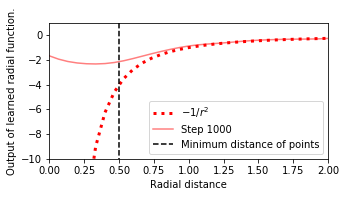

In [10]:
# plot radial function and compare with -1/r^2

radial_fig = plt.figure(figsize=(5,2.5))
ax = radial_fig.add_subplot(1,1,1)

min_index_cutoff = int((1 / sqrt(40.) - rbf_low) / rbf_spacing)
ax.plot(x_vals[min_index_cutoff:], [-1 / r_**2 for r_ in x_vals[min_index_cutoff:]], "r:", lw=3, label="$-1/r^2$")

for step, y_vals in F1_y_vals[1:]:
    line, = ax.plot(x_vals, y_vals, 'r', alpha=0.5, label="Step {}".format(step))
    line.set_ydata(y_vals)

ax.plot([min_separation, min_separation], [10,-50], 'k--', label="Minimum distance of points")
ax.set_ylabel("Output of learned radial function.")
ax.set_xlabel("Radial distance")
ax.set_xlim(0., 2.0)
ax.set_ylim(-10, 1.)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
radial_fig.canvas.draw()